# Review of Historical Crash Recovery Mission Data

## Scenario
Hours ago a high-value UAV crashed in a remote region of California.  A recovery beacon on the UAV is active but no GPS information is provided by the beacon, and all that is known is the general region of the crash based on the last received transponder information before communication failure.  Search operations are underway.  Cloud cover in the region is dense, preventing overhead assets from joining the search.  There are currently multiple field teams taking signal strength data using low-altitude handheld UAVs and those reports should arrive soon.

In the mean time, leadership has asked for your help. Before you begin analyzing live data from the current UAV recovery mission, you will come up to speed by reviewing historical data from a previous search event which resulted in a successful recovery operation.  This historical data contains the GPS coordinates of both the search teams and the actual beacon location for each observation. Since the location of the downed asset was known, you can determine critical feature—**distance**—and calibrate your analysis tools in a controlled, error-free environment.  

You will likely observe that the relationship between signal strength and distance to beacon is not simple since in a mountainous area, terrain between a beacon and a sensor often blocks & attenuates signals, and sometimes a recording which is far away from the beacon, but at a high altitude, might have a stronger signal than a sensor which is closer but blocked by terrain.

## Coding Task Overview
Your task is to:

1. **Load** the historical mission dataset into a pandas DataFrame and **visualize** the locations on a map.
2. **Create a function to Calculate** the distance (in meters) between each search team's reported location and the beacon using a geospatial library.
3. **Include** this new distance feature as a column in the DataFrame.
4. **Scatterplot** the relationship between distance and signal strength
5. **Save** the augmented DataFrame to a new CSV file for use in later analysis.

This calibration step will help ensure your code and methods are accurate before you tackle the more complex, real-world data from the current mission.

In [1]:
# Import pandas, geopy.distance, and seaborn/matplotlib.pyplot
import pandas as pd
from geopy.distance import geodesic
import os
import seaborn as sns
import matplotlib.pyplot as plt

### STEP 1a: Load the historical mission data from CSV into a DataFrame and display the first five rows to inspect the data.

STUDENT CODE REQUIRED


load the file ```historical_mission_data.csv``` from the ```data``` subdierectory using Pandas ```read_cv``` and store the data in a dataframe called ```df_hist``` 

In [2]:
DATA_DIR = 'data'
data_filename = os.path.join(DATA_DIR, 'historical_mission_data.csv')


##########################################################
##### START STUDENT CODE HERE:

# Load the historical_mission_data.csv file into a DataFrame called df_hist.
df_hist = pd.read_csv(data_filename)

# Display the first five rows of df_hist.
df_hist.head()

##### END STUDENT CODE HERE
##########################################################


,report_id,team_callsign,team_lat,team_lon,beacon_lat,beacon_lon,signal_strength
0,1,TEAM001,37.287270,-118.829571,37.35,-119.1,NaN
1,2,TEAM002,37.465997,-119.040805,37.35,-119.1,NaN
2,3,TEAM003,37.178009,-119.306403,37.35,-119.1,NaN
3,4,TEAM004,37.129042,-118.880294,37.35,-119.1,NaN
4,5,TEAM005,37.400558,-118.975156,37.35,-119.1,NaN


### STEP 1b: visualize the historical mission data from the DataFrame

STUDENT CODE REQUIRED

The map ```m``` will be created for you using the ```folium``` package.  Your first task is to add markers for each measurement collection points using their latitude and longitude information

add the location of the beacon


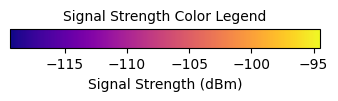

In [3]:
# Create an interactive map showing team locations and the beacon using folium, with signal strength color-coded using the plasma colormap.
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import base64
from io import BytesIO

# Center the map on the average team location
center_lat = df_hist['team_lat'].mean()
center_lon = df_hist['team_lon'].mean()
map_tiles = 'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png'
map_attr = 'Map data: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> contributors'
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles=map_tiles, attr=map_attr, control_scale=True)

# Normalize signal strength for colormap
signal = df_hist['signal_strength']
norm = mcolors.Normalize(vmin=signal.min(), vmax=signal.max())
cmap = plt.get_cmap('plasma')




# Add team locations as color-coded circle markers

for idx, row in df_hist.iterrows():
    
    # each row in the dataframe df_hist is a dictionary, so you can access the lat and lon using row['team_lat'] and row['team_lon']
    # create a location point which is a python list of lat, lon and store it in curr_location

    ##########################################################
    ##### START STUDENT CODE HERE:

    curr_location = [row['team_lat'], row['team_lon']]
    
    ##### END STUDENT CODE HERE
    ##########################################################

    fill_color = mcolors.to_hex(cmap(norm(row['signal_strength'])))
    folium.CircleMarker(
        location=curr_location,
        radius=7,
        color='red',  # Red outline
        weight=3,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.85,
        popup=f"Team: {row['team_callsign']}<br>Signal: {row['signal_strength']:.1f} dBm",
        tooltip=f"Signal: {row['signal_strength']:.1f} dBm"
    ).add_to(m)

# Add the beacon location to the map 

#The beacon location is the same for all rows, so we can just use the first row to get its lat and lon
#The first row can be accessed using df_hist.iloc[0]

##########################################################
##### START STUDENT CODE HERE:

beacon_location = [df_hist['beacon_lat'].iloc[0], df_hist['beacon_lon'].iloc[0]]

##### END STUDENT CODE HERE
##########################################################

folium.Marker(
    location=beacon_location,
    icon=folium.Icon(color='red', icon='star'), #as a red star marker
    popup='Beacon Location',
).add_to(m)

# Add a colorbar legend as an image overlay
fig, ax = plt.subplots(figsize=(4, 0.5))
fig.subplots_adjust(bottom=0.5)
cb1 = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax, orientation='horizontal',
    label='Signal Strength (dBm)'
)
ax.set_title('Signal Strength Color Legend', fontsize=10)
buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
plt.close(fig)
data = base64.b64encode(buf.getbuffer()).decode('ascii')
legend_html = f'<img src="data:image/png;base64,{data}" style="width:250px; margin: 10px; border:1px solid #888; background:white;">'
legend = folium.map.Marker(
    [df_hist['team_lat'].max(), df_hist['team_lon'].min()],
    icon=folium.DivIcon(html=legend_html)
)
m.add_child(legend)


try:
    display(m)
    #display(HTML(m._repr_html_()))
except Exception as e:
    print('Map display failed:', e)

### STEP 2: Define a function to calculate the distance (in kilometers) between each team's location and the beacon using geopy.

STUDENT CODE REQUIRED

Create a function called ```calculate_distance``` that takes a row of data from a dataframe as input.
Inside the function, it should extract the team and beacon coordinates using ```row['team_lat']```, ```row['team_lon']```, ```row['beacon_lat']```, and ```row['beacon_lon']```.
It should then use ```geopy.distance.great_circle``` to calculate the distance in kilometers and store it in distance_km.

the link for instructions on distance is https://geopy.readthedocs.io/en/stable/#module-geopy.distance
The function should return the calculated distance in kilometers.

In [4]:
# Create a function called calculate_distance that takes a row as input.
# Inside the function, it should extract the team and beacon coordinates 
#   using row['team_lat'], row['team_lon'], row['beacon_lat'], and row['beacon_lon'].
# It should then use geopy.distance.great_circle to calculate the distance in kilometers and store it in distance_km.
# the link for instructions on distance is https://geopy.readthedocs.io/en/stable/#module-geopy.distance
# The function should return the calculated distance.
from geopy.distance import great_circle

def calculate_distance(row):
    


    ##########################################################
    ##### START STUDENT CODE HERE:
    
    team_coords = (row['team_lat'], row['team_lon'])

    beacon_coords = (row['beacon_lat'], row['beacon_lon'])

    distance_km = great_circle(team_coords, beacon_coords).km
    
    ##### END STUDENT CODE HERE
    ##########################################################


    return distance_km

### STEP 3: Apply your distance function to each row to create a new column 'distance_to_beacon_km', then display the updated DataFrame.

STUDENT CODE REQUIRED

Next use the method ```.apply()``` on the ```df_hist``` *on each row* in order to generate new columns as a function of information in existing columns values in that row.
The form of the function is ```df_hist.apply(FUNCTION_NAME), axis=1)``` where FUNCTION_NAME is a previously defined function which accepts a row from the dataframe and returns a value


Apply the ```calculate_distance``` function to the ```df_hist``` DataFrame to 
create a new column named ```'distance_to_beacon_km'``` using the dataframe's ```.apply``` method on ```axis=1```

Apply the ```calculate_distance``` function to the ```df_hist``` DataFrame to 
create a new column named ```'elevation'``` using the dataframe's ```.apply``` method on ```axis=1```


then Display the first few rows of the DataFrame with the new column using the DataFrame's ```.head()``` accessor

In [5]:


##########################################################
##### START STUDENT CODE HERE:

# Apply the calculate_distance function to the df_hist DataFrame to 
# create a new column named 'distance_to_beacon_km' using the dataframe's .apply method on axis=1

df_hist['distance_to_beacon_km'] = df_hist.apply(calculate_distance, axis=1)


# then display the DataFrame with the new column using .head()

df_hist.head()

##### END STUDENT CODE HERE
##########################################################

,report_id,team_callsign,team_lat,team_lon,beacon_lat,beacon_lon,signal_strength,distance_to_beacon_km
0,1,TEAM001,37.287270,-118.829571,37.35,-119.1,NaN,24.910715
1,2,TEAM002,37.465997,-119.040805,37.35,-119.1,NaN,13.917705
2,3,TEAM003,37.178009,-119.306403,37.35,-119.1,NaN,26.445814
3,4,TEAM004,37.129042,-118.880294,37.35,-119.1,NaN,31.335730
4,5,TEAM005,37.400558,-118.975156,37.35,-119.1,NaN,12.381527


### STEP 4: Create a scatter plot to visualize the relationship between distance to the beacon (km) and signal strength (in dBm).

STUDENT CODE REQUIRED

Create a scatter plot using seaborn (```sns.scatterplot```) on the ```df_hist``` dataframe to visualize the relationship between
```'distance_to_beacon_km'``` (x-axis) and ```'signal_strength'``` (y-axis). 
Add a title and labels (using ```.title()```, ```.xlabel()``` and ```.ylabel()``` ) and then show the plot using ```.show()```.




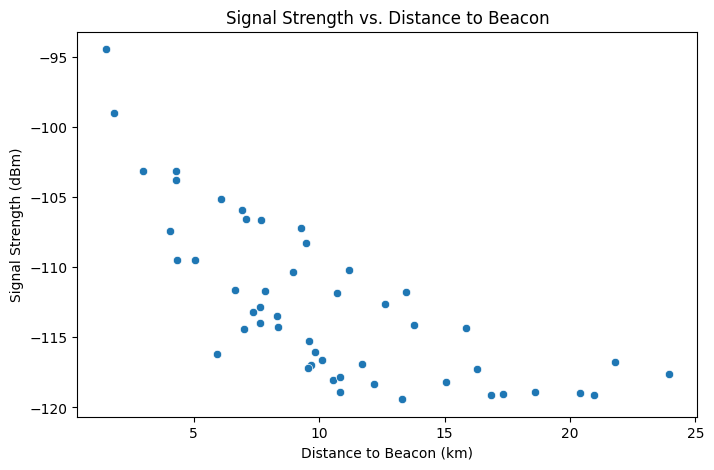

In [6]:

##########################################################
##### START STUDENT CODE HERE:


# Create a scatter plot using seaborn (sns.scatterplot) on the df_hist dataframe to visualize the relationship between
# 'distance_to_beacon_km' (x-axis) and 'signal_strength' (y-axis).
# Add a title and labels and then show the plot.

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_hist, x='distance_to_beacon_km', y='signal_strength')
plt.title('Signal Strength vs. Distance to Beacon')
plt.xlabel('Distance to Beacon (km)')
plt.ylabel('Signal Strength (dBm)')
plt.show()


##### END STUDENT CODE HERE
##########################################################

### STEP 5: Save your updated DataFrame to a new CSV file ```historical_mission_verified.csv``` in the ```data``` subdirectory for later use.

No student code required

In [7]:
# Save the updated df_hist DataFrame to a new CSV file named 'historical_mission_verified.csv'.
# Make sure not to include the pandas index in the saved file and save it to the data subdirectory.
# Print a confirmation message indicating the file has been saved.
output_path = os.path.join(DATA_DIR, 'historical_mission_verified.csv')
df_hist.to_csv(output_path, index=False)
print(f"File '{output_path}' has been saved.")

File 'data\historical_mission_verified.csv' has been saved.
